In [260]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as colors
import yaml
import pandas as pd
import scipy.signal as signal
import scipy.stats as stats

In [261]:
mouse = 'TAA0000066'
session = '-t12'
date = '20250129'
base_path = 'D:/ExampleMouse/'

session_path = 'D:/ExampleMouse/TAA0000066/ses-018_date-20250403_protocol-t12/'
imaging_path = 'D:/ExampleMouse/TAA0000066/ses-018_date-20250403_protocol-t12/funcimg/Session/suite2p/plane0'
frame_ix = np.load(os.path.join(session_path, 'valid_frames.npz'))

In [262]:
#load the imaging data
f = np.load(os.path.join(imaging_path, 'F.npy'))
fneu = np.load(os.path.join(imaging_path, 'Fneu.npy'))
spks = np.load(os.path.join(imaging_path, 'spks.npy'))
iscell = np.load(os.path.join(imaging_path, 'iscell.npy'))
ops = np.load(os.path.join(imaging_path, 'ops.npy'), allow_pickle=True).item()
seg = np.load(os.path.join(imaging_path, 'meanImg_seg.npy'), allow_pickle=True).item()

In [263]:
import parse_session_functions
session = parse_session_functions.analyse_npz(mouse,date,plot=False)

c:\Users\Sumiya\miniconda3\envs\suite2p2\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Sumiya\miniconda3\envs\suite2p2\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Performance =  0.7336947278911565
Number of laps =  109


c:\Users\Sumiya\Workstation2025\VR_ABCD\notebook\parse_session_functions.py:384: RuntimeWarning: Mean of empty slice
  av_speed_per_bin = np.nanmean(speed_per_bin, axis=0)
c:\Users\Sumiya\miniconda3\envs\suite2p2\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Sumiya\Workstation2025\VR_ABCD\notebook\parse_session_functions.py:405: RuntimeWarning: Mean of empty slice
  state1_speed = np.nanmean(state1_laps, axis=0)
c:\Users\Sumiya\Workstation2025\VR_ABCD\notebook\parse_session_functions.py:407: RuntimeWarning: Mean of empty slice
  state2_speed = np.nanmean(state2_laps, axis=0)
c:\Users\Sumiya\Workstation2025\VR_ABCD\notebook\parse_session_functions.py:410: RuntimeWarning: Mean of empty slice
  state3_speed = np.nanmean(state3_laps, axis=0)


In [264]:
import sandra

In [265]:
session = sandra.add_time(session)
session = sandra.add_lick_rate(session)
session = sandra.add_thlick_rate(session)
session = sandra.add_lick_array(session)

In [266]:
first_frame = 31670
last_frame = 36777
good_ids =  [364, 315, 279, 254, 344, 343]

In [267]:
# calculate df/f
iscell = iscell.astype(bool)
cells_f = f[iscell[:,0],:]
cells_fneu = fneu[iscell[:,0],:]
cells_spks = spks[iscell[:,0],:]

cells_f = f[:,frame_ix['valid_frames']]
cells_fneu = fneu[:,frame_ix['valid_frames']]
cells_spks = cells_spks[:,frame_ix['valid_frames']]

cells_f_corr = (cells_f - cells_fneu*0.7)
f0 = np.percentile(cells_f, 25, axis=1)
cells_df = ((cells_f_corr.T - f0)/f0).T

In [268]:
from scipy.ndimage import percentile_filter

In [269]:
# calculate df/f
cells_f_corr = (f - fneu*0.7)
f0 = np.percentile(f, 25, axis=1)
cells_df_all = ((cells_f_corr.T - f0)/f0).T

In [24]:
# perform dF/F computation using a moving percentile approach
dFF = np.zeros((f.shape))
num_cells = f.shape[0]
for k in range(num_cells):
    # subtract neuropil with a factor of 0.15 (may also use 0.00, since neuropil contamination for HC 2P imaging not very strong typically)
    corrected_fluorescence = f[k,:] - 0.15*fneu[k,:]
    
    F0 = percentile_filter(corrected_fluorescence,15,size=45*60)
    
    dFF[k,:] = (corrected_fluorescence - F0)/(F0)
    if np.mod(k,50) == 0:
        print((k+1)/num_cells*100)

cells_df_all = dFF

0.1855287569573284
9.461966604823747
18.738404452690165
28.014842300556587
37.291280148423006
46.567717996289424
55.84415584415584
65.12059369202227
74.39703153988869
83.6734693877551
92.94990723562152


NameError: name 'dff' is not defined

In [270]:
frame_rate = 45
x = np.arange(0, cells_df[:,first_frame:last_frame].shape[1])/frame_rate

In [11]:
#create reward_psth for all cells
window = np.arange(-22, 22)
reward_idx = session['rewards']
all_cells_avg = np.zeros((cells_df.shape[0], len(window)))
for c in range(cells_df.shape[0]):
    cell_rewards = np.zeros((len(window), len(reward_idx)))
    for i in range(len(reward_idx)):
        reward = reward_idx[i]
        # print(reward)
        if reward+window[-1] < len(cells_df[c,:]):
            cell_rewards[:,i] = cells_df[c, reward+window]
        else:
            cell_rewards[:,i] = cells_df[c, reward:len(cells_df[c,:])]
    cell_rewards_avg = np.mean(cell_rewards, axis=1)
    cell_rewards_std = np.std(cell_rewards, axis=1)
    cell_rewards_sem = cell_rewards_std/np.sqrt(len(reward_idx))
    all_cells_avg[c,:] = cell_rewards_avg

all_cells_avg = stats.zscore(all_cells_avg, axis=1)


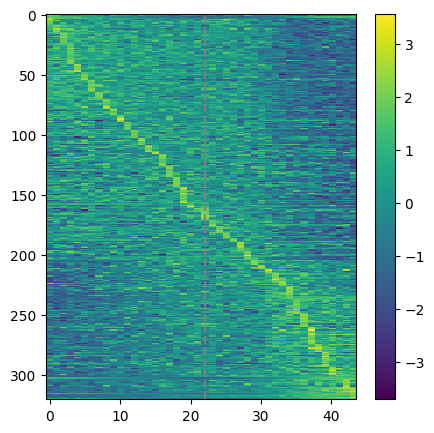

In [12]:
sortidx = np.argsort(np.argmax(all_cells_avg, axis=1))
# sortidx = np.arange(0,all_cells_avg.shape[0]) #to switch off sorting
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(all_cells_avg[sortidx,:], aspect='auto', interpolation='none')
cbar = plt.colorbar(ax.imshow(all_cells_avg[sortidx,:], aspect='auto', interpolation='none'), ax=ax)
#draw a vertical line at reward time
ax.axvline(x=22, color='gray', linestyle='--')

In [271]:
first_frame = 31670
last_frame = 36777

In [14]:
last_frame = 36777

In [272]:
cell_id = good_ids[5] # 5 #0 # 4?

In [220]:
good_ids

[364, 315, 279, 254, 344, 343]

In [273]:
df = pd.DataFrame({'position': session['position'][first_frame:last_frame],
              'lickrate': session['lick_array'][first_frame:last_frame],
              'dff': cells_df_all[cell_id,first_frame:last_frame]
              }, index=np.linspace(0,(last_frame-first_frame)/45, last_frame-first_frame))

somerandombarcode_df = sandra.get_somerandombarcode_df(190, last_frame-first_frame)

Text(0, 0.5, 'dF/F')

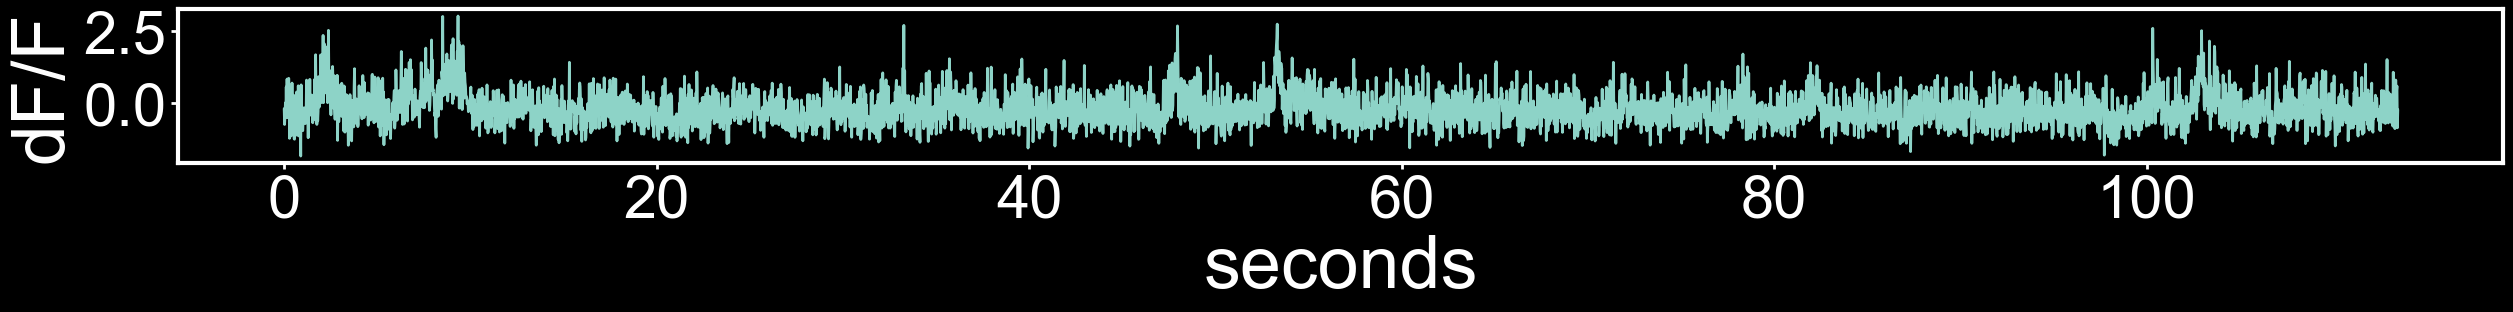

In [274]:
sessionfig, ax = plt.subplots(1,1, figsize=(30,2))
ax.plot(df['dff'], label='Cell 1')
# ax.plot(cells_df[99,:], label='Cell 1')

ax.set_xlabel('seconds')
ax.set_ylabel('dF/F')

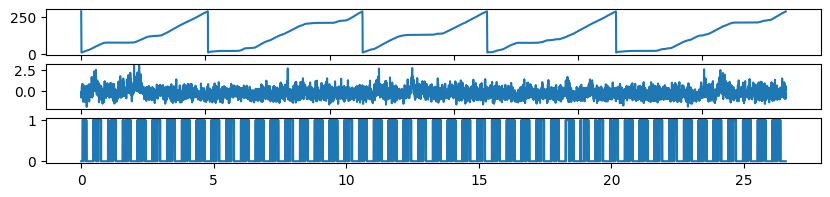

In [275]:
plt.style.use('default')

fig, axs = plt.subplots(3,1, figsize=(10,2))
axs[0].plot(df['position'], label='Cell 1')
axs[1].plot(df['dff'], label='Cell 1')
axs[2].plot(somerandombarcode_df, label='Cell 1')

# ax.plot(cells_df[99,:], label='Cell 1')

# ax.set_xlabel('seconds')
# ax.set_ylabel('dF/F')

Text(0.5, 0, 'seconds')

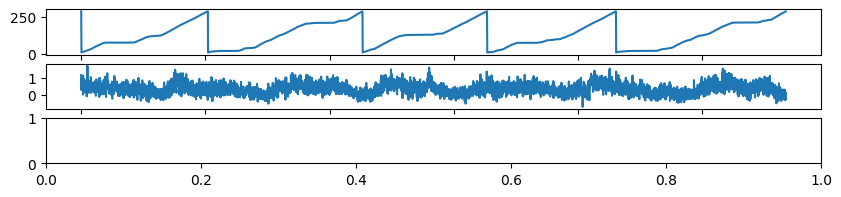

In [224]:
fig, axs = plt.subplots(3,1, figsize=(10,2))
axs[0].plot(df['position'], label='Cell 1')
axs[1].plot(df['dff'], label='Cell 1')
# axs[2].plot(somerandombarcode_df, label='Cell 1')
# ax.plot(cells_df[99,:], label='Cell 1')

axs[1].set_xlabel('seconds')
# ax.set_ylabel('dF/F')

Text(0, 0.5, 'dF/F')

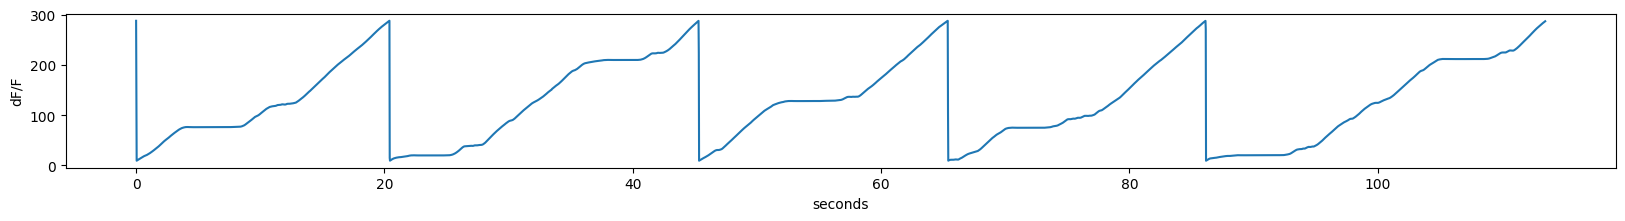

In [225]:
sessionfig, ax = plt.subplots(1,1, figsize=(20,2))
ax.plot(df['position'], label='Cell 1')
# ax.plot(cells_df[99,:], label='Cell 1')

ax.set_xlabel('seconds')
ax.set_ylabel('dF/F')

Text(0, 0.5, 'dF/F')

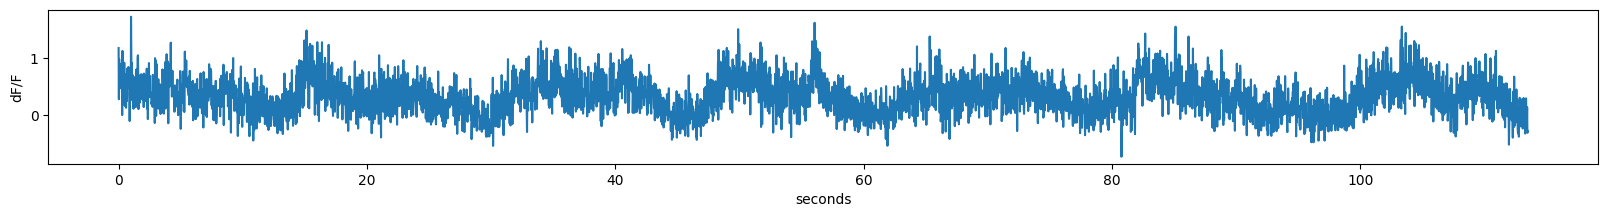

In [226]:
sessionfig, ax = plt.subplots(1,1, figsize=(20,2))
ax.plot(df['dff'], label='Cell 1')
# ax.plot(cells_df[99,:], label='Cell 1')

ax.set_xlabel('seconds')
ax.set_ylabel('dF/F')

In [190]:
45*60

2700

In [191]:
df.head(2944)

,position,lickrate,dff
0.000000,287.687119,False,1.174219
0.022227,131.213814,False,0.277775
0.044453,9.293705,False,0.983023
0.066680,9.610601,False,0.553066
0.088906,9.990851,False,0.902413
...,...,...,...
65.323902,286.919933,False,1.377291
65.346129,287.307002,False,0.766071
65.368355,287.664788,False,0.701397
65.390582,108.517423,False,0.379869


Text(0, 0.5, 'dF/F')

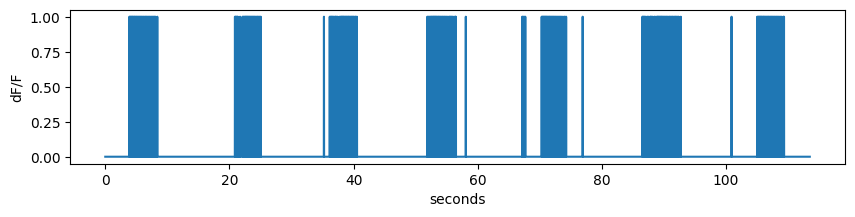

In [192]:
fig, ax = plt.subplots(1,1, figsize=(10,2))
ax.plot(df['lickrate'], label='Cell 1')
# ax.plot(cells_df[99,:], label='Cell 1')

ax.set_xlabel('seconds')
ax.set_ylabel('dF/F')

In [283]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [284]:
import matplotlib.font_manager as fm
fm.fontManager.addfont('./Arial.ttf')
RC_PARAMS = {
    'font.family': 'Arial', # 'LiberationSans-Regular', # if you have Liberation2 installed
    'font.size': 43,
    'lines.linewidth': 2,
    'lines.markersize': 2.5,
    'axes.linewidth': 3,
    'xtick.major.width': 2,
    'ytick.major.width': 2,
    'axes.titlesize': 53,
    'axes.labelsize': 53,
    'xtick.major.size': 4,
    'ytick.major.size': 5,
    'xtick.labelsize': 43,
    'ytick.labelsize': 43
}

In [286]:
import seaborn as sns
sns.set(style='ticks')
sns.set_context('paper', rc=RC_PARAMS)
plt.style.use('dark_background')

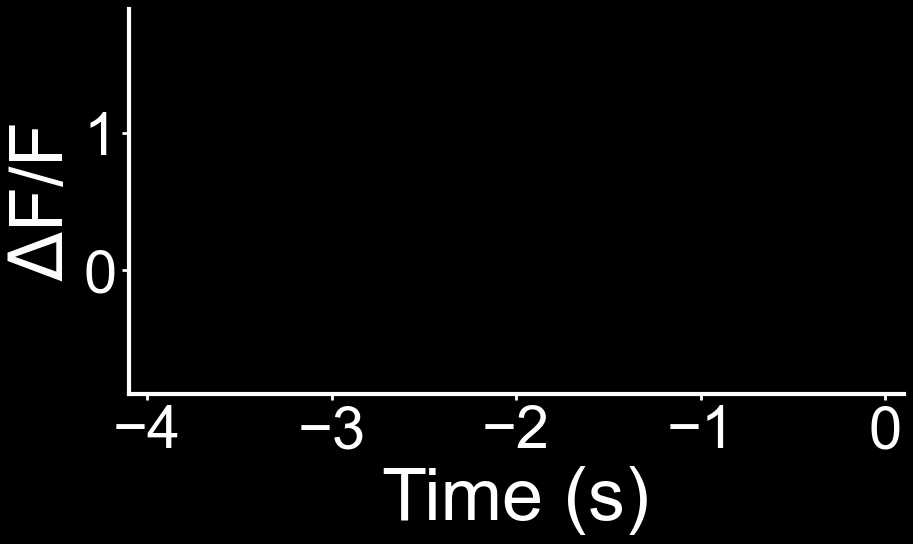

In [230]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import matplotlib.ticker as ticker

# Generate random data
data = df['dff'].values  # Ensures range is [-2, 2]

# Parameters
repeat_length = 180  # Rolling window size

# Set up the figure and axis
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], lw=5, color='cyan')
ax.set_ylim(-0.9, 1.9)
ax.set_xlim(-4.1, 0.1)
ax.set_ylabel(r'$\Delta$F/F')
ax.set_xlabel('Time (s)')

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Update function
def update(frame):
    if frame == 0:
        return line,  # Skip empty frame to avoid errors

    x_vals = np.linspace(-4, 0, repeat_length)

    if frame > repeat_length:
        y = data[frame - repeat_length:frame]
        x = x_vals
    else:
        y = data[:frame]
        x = x_vals[-frame:]

    line.set_data(x, y)
    return line,

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(data),
    init_func=init, blit=True, interval=1000/45
)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

# Display the animation
plt.show()

In [109]:
def handle_errorbar(ax, dta0, dta1=None, x=0, col='k', label='', alpha=1.0, clip_on=False, style=[], **kwargs):
    if 'line' in style:
        ax.plot(dta0, color=col, label=label, alpha=alpha, clip_on=clip_on, **kwargs)
    if 'line_xranged' in style:
        ax.plot(dta0, dta1, color=col, label=label, alpha=alpha, clip_on=clip_on, **kwargs)
    if 'shaded-errorbar-diff' in style:
        ax.fill_between(
            dta0.index, dta1.loc[0.025], dta1.loc[0.975],
            alpha=alpha, lw=0, color=col, clip_on=clip_on, **kwargs)
    if 'shaded-errorbar-diff005' in style:
        ax.fill_between(
            dta0.index, dta1.loc[0.05], dta1.loc[0.95],
            alpha=alpha, lw=0, color=col, clip_on=clip_on, **kwargs)
    if 'shaded-errorbar-diff010' in style:
        ax.fill_between(
            dta0.index, dta1.loc[0.1], dta1.loc[0.9],
            alpha=alpha, lw=0, color=col, clip_on=clip_on, **kwargs)
    if 'shaded-errorbar-actual' in style:      
        err = np.array([dta0 - dta1.loc[0.025], 
                        dta1.loc[0.975] - dta0]) # calculates difference
        ax.errorbar(dta0.index, dta0, yerr=err, 
                    color=col, marker='o', linestyle='',
                    clip_on=clip_on, **kwargs)
        ax.fill_between(
            dta0.index, dta1.loc[0.025], dta1.loc[0.975],
            alpha=alpha, lw=0, color=col, clip_on=clip_on, **kwargs)
    if 'errorbar-diff' in style:
        ax.errorbar(dta0.index, dta0, 
                    yerr=np.array(dta1.loc[0.025], dta1.loc[0.975]),
                    color=col, marker='o', linestyle='',
                    clip_on=clip_on, **kwargs)
    if 'errorbar-actual' in style:
        err = np.array([dta0 - dta1.loc[0.025], 
                        dta1.loc[0.975] - dta0]) # calculates difference
        ax.errorbar(dta0.index, dta0, yerr=err, 
                    color=col, marker='o', linestyle='',
                    clip_on=clip_on, **kwargs)

In [231]:
from matplotlib.animation import FFMpegWriter

# Set up MP4 writer
writer = FFMpegWriter(fps=60, metadata=dict(artist='Sumiya'), bitrate=1800)

# Save the animation
ani.save("./animation_0.avi", writer=writer)

In [99]:
# Save the animation
ani.save('animation.gif', writer='pillow', fps=60)

In [276]:
neural_data = np.load('./neural_data.npy')

In [277]:
this_trial_data = neural_data[10,:,:]

In [278]:
def count_binary(arr):
    result = [arr[0]]
    for x in arr[1:]:
        if x ==1:
            result.append(result[-1] + 1)
        else:
            result.append(result[-1])

    return np.array(result)

In [279]:
iscell_extended = count_binary(iscell[:,0])

In [307]:
iscell_extended[344]

204

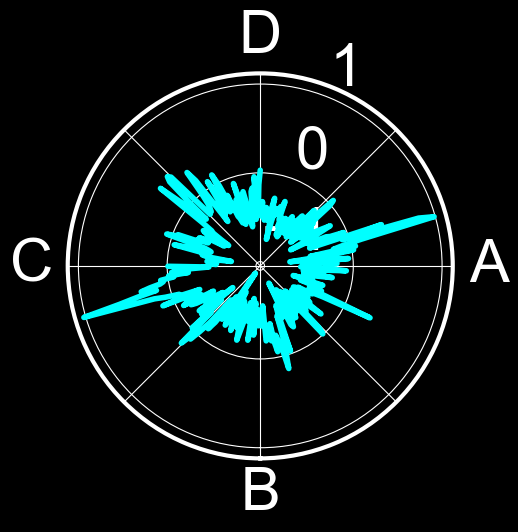

In [320]:
#plot one line (single cell) of the above as a polar plot
fig, ax = plt.subplots(1,1, figsize=(5,5), subplot_kw=dict(polar=True))
ax.plot(np.linspace(0, 2*np.pi, 360), this_trial_data[204,:], color='cyan', lw=4)
ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
ax.set_xticklabels(['B', '', 'A', '', 'D', '', 'C', ''])
# ax.set_yticks([])
ax.set_thetalim(-np.pi, np.pi)
ax.tick_params(pad=15) 
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

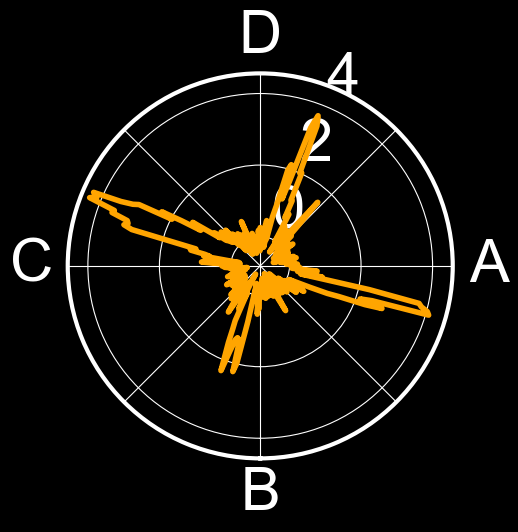

In [315]:
#plot one line (single cell) of the above as a polar plot
fig, ax = plt.subplots(1,1, figsize=(5,5), subplot_kw=dict(polar=True))
ax.plot(np.linspace(0, 2*np.pi, 360), this_trial_data[198,:], color='orange', lw=4)
ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
ax.set_xticklabels(['B', '', 'A', '', 'D', '', 'C', ''])
# ax.set_yticks([])
ax.set_thetalim(-np.pi, np.pi)
ax.tick_params(pad=15) 
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

In [338]:
data = np.roll(this_trial_data[204,:],-90)

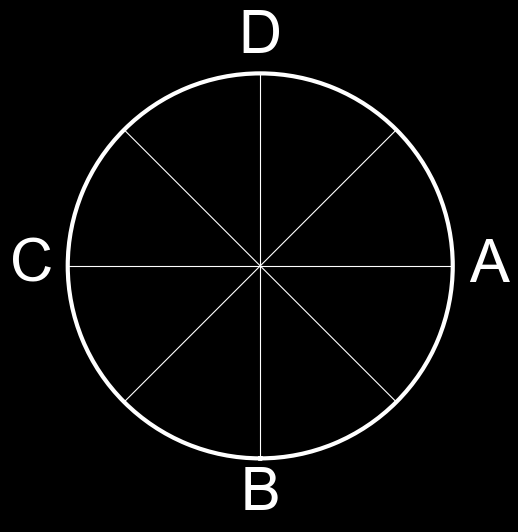

In [339]:
# Set up the figure and axis
plt.style.use('dark_background')
fig, ax = plt.subplots(1,1, figsize=(5,5), subplot_kw=dict(polar=True))
line, = ax.plot([], [], color='cyan', lw=4)
ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 8, endpoint=False))
ax.set_xticklabels(['B', '', 'A', '', 'D', '', 'C', ''])
ax.set_yticks([])
ax.set_thetalim(-np.pi, np.pi)
ax.set_ylim(-0.9, 1.1)
ax.tick_params(pad=15) 
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Update function
def update(frame):
    if frame == 0:
        return line,  # Skip empty frame to avoid errors

    x_vals = np.linspace(0.5*np.pi, 2.5*np.pi, 360)

    y = data[:frame]
    x = x_vals[:frame]

    line.set_data(x, y)
    return line,

# Create animation
ani = animation.FuncAnimation(
    fig, update, frames=len(data),
    init_func=init, blit=True, interval=1000/60
)

# Display the animation
plt.show()

In [340]:
from matplotlib.animation import FFMpegWriter

# Set up MP4 writer
writer = FFMpegWriter(fps=60, metadata=dict(artist='Sumiya'), bitrate=1800)

# Save the animation
ani.save("./animation_204v2.avi", writer=writer)